In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import altair as alt
import pandas as pd

from glob import glob
from copy import deepcopy
from pypdb import Query, get_pdb_file
from rcsbsearchapi.search import AttributeQuery
from Bio import AlignIO
from anytree import RenderTree

import dist_analy.import_pdb
import dist_analy.pca
from dist_analy.determine_seq import get_and_align_sequence, get_conserved, get_klifs_res, def_union
from dist_analy.util.pdb_info import pdb_csv, get_any_info, pdb_read_csv
from dist_analy.dist_analy import get_shortest_dist_matrix, get_ca_dist_matrix
from dist_analy.tree_analysis import TreeNode
from dist_analy.data_viz import alt_pca_hdbscan_figure, jchart_query, py3Dmol_lig_pose

# import dist_analy.alphaspace2 as AS2
# from dist_analy.alphaspace2.Community import get_community, view_surf_community, view_pocket
# from dist_analy.alphaspace2.Dock import DockPrep

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
UNIPROT_LIST = ["P06493", "P24941", "Q00526", "P11802", "Q00535", "Q00534", "P50613", "P49336", "P50750", "Q15131", "Q9UQ88", "P21127", "Q9NYV4", \
"Q14004", "O94921", "Q96Q40", "Q00536", "Q00537", "Q07002", "Q9BWU1", "Q8IZL9"]
CDK1_20 = ['CDK1_HUMAN','CDK2_HUMAN','CDK3_HUMAN','CDK4_HUMAN','CDK5_HUMAN','CDK6_HUMAN','CDK7_HUMAN','CDK8_HUMAN','CDK9_HUMAN','CDK10_HUMAN','CD11A_HUMAN','CD11B_HUMAN','CDK12_HUMAN','CDK13_HUMAN','CDK14_HUMAN','CDK15_HUMAN','CDK16_HUMAN','CDK17_HUMAN','CDK18_HUMAN','CDK19_HUMAN','CDK20_HUMAN']

# alignment = get_and_align_sequence( './datafiles/', 'CDK1_20', UNIPROT_LIST, prot_list=CDK1_20)
align = AlignIO.read('./datafiles/align/CDK1_20.al', "clustal")
cons_id = get_conserved(align)
cons_id_1 = get_conserved(align, semi=True)
# klifs_res = get_klifs_res('3BHT','A')
klifs_res = [res for res in get_klifs_res('1FIN','A') if res]
cdk2_klifs_ident, union_id = def_union(cons_id[CDK1_20.index('CDK2_HUMAN')], klifs_res)

In [3]:
color_list = ['red', 'orange_red_1', 'yellow', 'green_1', 'dark_green', 'cyan', 'blue', 'purple_1b', 'magenta'] ## change to hex code
color_list = ['#e50000', '#f97306', '#ceb301', '#96f97b', '#06470c', '#00ffff', '#0343df', '#7e1e9c', '#cb416b']
# color code = [ Gly-rich, aC-helix, Hinge, Catalytic Loop, KEDD residues, AS, aF-helix ]
cdk2_color_res_list = [np.arange(12,17), np.delete(np.arange(45,58), np.where(np.arange(45,58)==51)), \
              np.arange(80,87), np.delete(np.arange(125,132), np.where(np.arange(125,132)==127)), \
               np.array([33,51,127,145]), np.arange(146,172),np.arange(182,197)]

color_cdk2 = dist_analy.pca.color_text(color_list, cdk2_color_res_list)

In [4]:
uniprot_root = 'https://www.ebi.ac.uk/proteins/api/proteins/'
uniprot_seq_cdk2 = get_any_info(uniprot_root, UNIPROT_LIST[CDK1_20.index('CDK2_HUMAN')])["sequence"]["sequence"]

In [5]:
cdk2_uniprot = 'P24941'

q1 = AttributeQuery(attribute="rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession", operator="exact_match", value=cdk2_uniprot)
q2 = AttributeQuery(attribute="rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_name", operator="exact_match", value="UniProt")

found_pdbs = list((q1&q2).exec())

In [6]:
# csv_dict, csv_df = pdb_csv(found_pdbs, cdk2_uniprot, "CDK2_pdb.csv")
csv_dict, csv_df = pdb_read_csv("CDK2_pdb.csv", chain=False)

In [7]:
csv_df = csv_df.loc[csv_df.Date < "2023-04-13"]

In [8]:
outdir = './datafiles/raw_pdb/'
for pdb in csv_df["PDB ID"]:
    fn = f"{outdir}{pdb}.pdb"
    if not os.path.exists(fn):
        print(pdb)
        pdb_file = get_pdb_file(pdb, filetype='pdb', compression=False)
        with open(fn,'w') as f1:
            f1.write(pdb_file)

In [9]:
pdb_dir = './datafiles/raw_pdb/'
proc_dir = './datafiles/proc_pdb/CDK2/'

proc_pdb_list = []
NCAA = ['TPO', 'CSD', 'KCX', 'CSD', 'PTR', 'OCS', 'ALY']
pdb_proc = dist_analy.import_pdb.PDB_Processer(NCAA, select=None)
for pdb in csv_df["PDB ID"]:
    if not glob(f"{proc_dir}{pdb}_*.pdb"):
        print(pdb)
        try:
            pdb_list = pdb_proc.process_pdb(f'{pdb}.pdb', pdb_dir, proc_dir, cdk2_uniprot)
            for proc in pdb_list:
                print(proc)
                proc_pdb_list.append(proc)
        except Exception as e:
            print(e)

In [10]:
save_dir = "./datafiles/npy/CDK2_all_res/"
dist_mat_list_0 = []
dist_mat_pdb_0 = []
# for proc_npy in glob(save_dir+'*.npy'):
for pdb in csv_df["PDB ID"]:
    for proc_npy in glob(f"{save_dir}{pdb}_*.npy"):
        pdb_chain = proc_npy.split("/")[-1].split(".")[0]
        dist_mat = np.load(proc_npy)
        dist_mat_list_0.append(dist_mat)
        dist_mat_pdb_0.append(pdb_chain) 

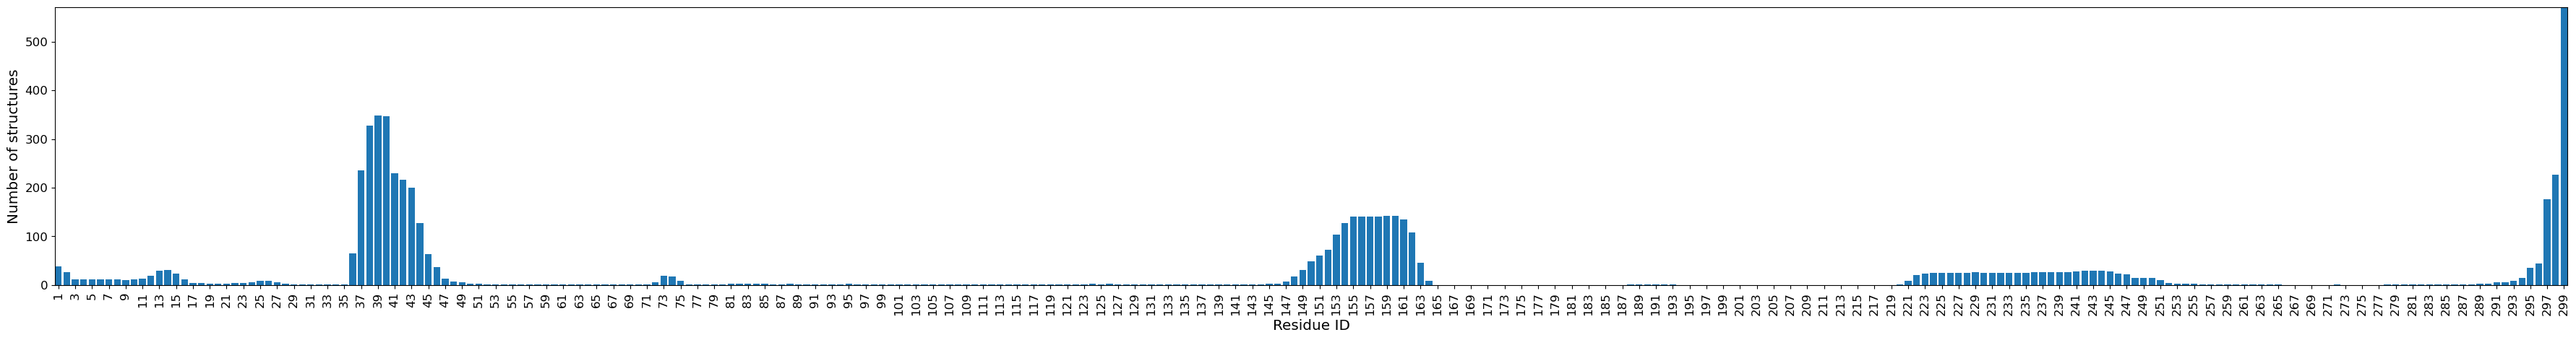

In [11]:
missing_pdb, missing_res = dist_analy.pca.hist_missing_residue(dist_mat_list_0, np.arange(1,300))

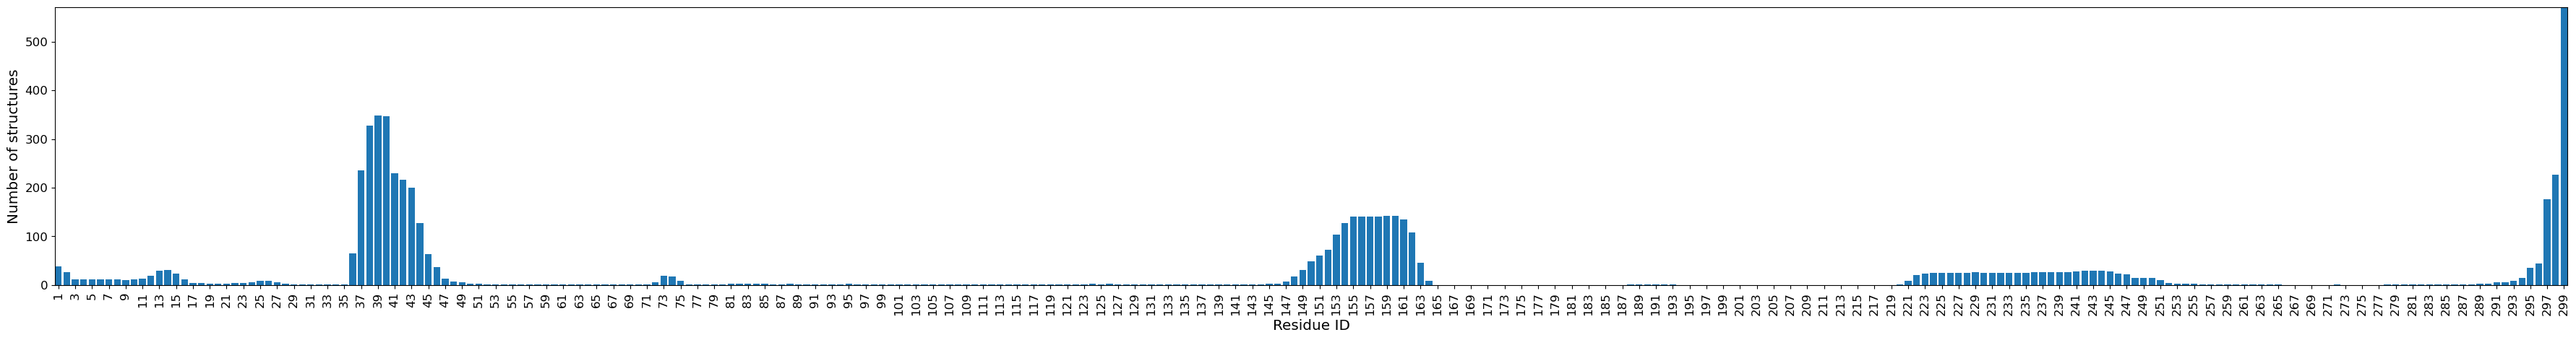

In [12]:
res_get = [33,51,145,146,147]
missing_dfg = dist_analy.pca.hist_missing_residue(dist_mat_list_0, np.arange(1,300), res_get)

pdb structures missing 40 residues: 4 {'4D1Z_A', '8OR0_H', '7RWE_A', '7UXK_A'}


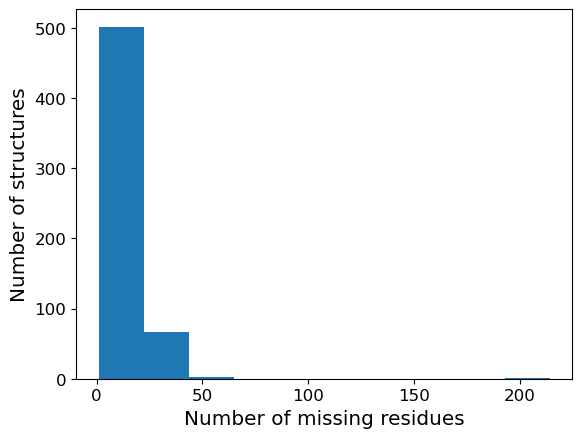

In [13]:
cutoff = 40
missing_fifty = dist_analy.pca.hist_missing_structure(dist_mat_list_0, cutoff = cutoff)
print(f"pdb structures missing {cutoff} residues: {len(missing_fifty)}",set([dist_mat_pdb_0[x] for x in missing_fifty]))

In [14]:
for x in missing_fifty[::-1]:
    del dist_mat_list_0[x]
    del dist_mat_pdb_0[x]

removing residues not available in every structure
original length of residue list 299; remove 123 residues
Cumulative explained variance > 0.7: 0.75, 0.04
0 []
309 ['1AQ1_A' '1B38_A' '1B39_A' '1BUH_A' '1CKP_A' '1DI8_A' '1DM2_A' '1E1V_A'
 '1E1X_A' '1FVT_A' '1G5S_A' '1GIH_A' '1GII_A' '1GIJ_A' '1GZ8_A' '1H00_A'
 '1H01_A' '1H07_A' '1H08_A' '1H0V_A' '1H0W_A' '1HCK_A' '1HCL_A' '1JSV_A'
 '1JVP_P' '1KE5_A' '1KE6_A' '1KE7_A' '1KE8_A' '1KE9_A' '1OIQ_A' '1OIR_A'
 '1OIT_A' '1P2A_A' '1PF8_A' '1PW2_A' '1PXI_A' '1PXJ_A' '1PXK_A' '1PXL_A'
 '1PXM_A' '1PXN_A' '1PXO_A' '1PXP_A' '1PYE_A' '1R78_A' '1URW_A' '1V1K_A'
 '1VYZ_A' '1W0X_C' '1W8C_A' '1WCC_A' '1Y8Y_A' '1Y91_A' '1YKR_A' '2A0C_X'
 '2A4L_A' '2B52_A' '2B53_A' '2B54_A' '2B55_A' '2BHE_A' '2BHH_A' '2BTR_A'
 '2BTS_A' '2C5Y_A' '2C68_A' '2C69_A' '2C6I_A' '2C6K_A' '2C6L_A' '2C6M_A'
 '2C6O_A' '2CLX_A' '2DS1_A' '2DUV_A' '2EXM_A' '2FVD_A' '2J9M_A' '2R3F_A'
 '2R3G_A' '2R3H_A' '2R3I_A' '2R3J_A' '2R3K_A' '2R3L_A' '2R3M_A' '2R3N_A'
 '2R3O_A' '2R3P_A' '2R3Q_A' '2R3

/Users/ericchen/opt/anaconda3/envs/dist_analy.publish/lib/python3.9/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:821: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.labels_, self.probabilities_ = tree_to_labels(
/Users/ericchen/opt/anaconda3/envs/dist_analy.publish/lib/python3.9/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:821: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.labels_, self.probabilities_ = tree_to_labels(


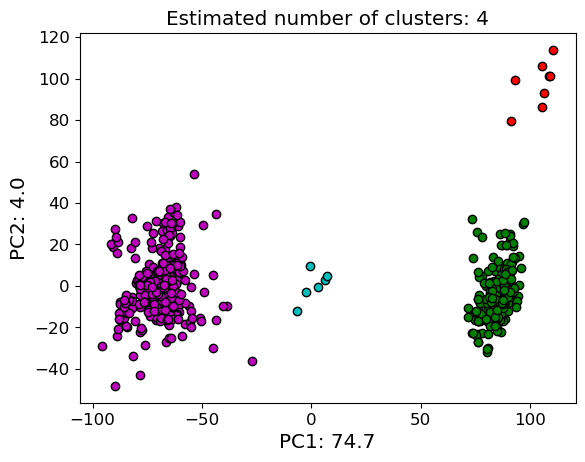

In [15]:
dist_mat_list_0 = np.array(dist_mat_list_0)
proj_coords_0, labels_0, dist_mats_0, res_list_0, ind_list_0, pca_0, hdb_0 = \
        dist_analy.pca.run(dist_mat_list_0, np.arange(1,300), cumsum=0.7, \
                           hdbscan_args={"cluster_selection_epsilon": 15}, color_list = ['m', 'c', 'g', 'r'])

inds_fc_0 = [[j for j,l in enumerate(labels_0) if l==i ] for i in range(-1,max(labels_0)+1)]
for ind_fc in inds_fc_0:
    print(len(ind_fc), np.asarray(dist_mat_pdb_0)[ind_fc])

In [101]:
df_pca_ro = pd.DataFrame({"PDB_chain": dist_mat_pdb_0, "pca1": proj_coords_0[:,0],"pca2": proj_coords_0[:,1], "label":labels_0})
df_pca_ro["PDB"] = df_pca_ro.PDB_chain.str[:4]
df_pca_ro = df_pca_ro.merge(csv_df.rename(columns={"PDB ID": "PDB"}), how="left", on="PDB")

txt_dir =  {"PDB_chain:N":"PDB_chain", "label:N":"label", "Polymer Binders:N": "Polymer Binders"}

jchart = alt_pca_hdbscan_figure(df_pca_ro[["PDB_chain", "pca1", "pca2", "label", "Polymer Binders"]], txt_dir)
jchart

JupyterChart(spec={'config': {'view': {'continuousWidth': 300, 'continuousHeight': 300, 'strokeWidth': 0}}, 'h…

In [99]:
df_q = jchart_query(df_pca_ro[["PDB_chain", "pca1", "pca2", "label", "Polymer Binders"]], jchart, return_col = ["PDB_chain", "label"])

rec_list = [f"{proc_dir}/{pdb_chain}.pdb" for pdb_chain in df_q.PDB_chain]
chain_list = [pdb_chain[5] for pdb_chain in df_q.PDB_chain]
rec_color_list = ['purple', 'cyan', 'green', 'red']

py3Dmol_lig_pose(rec_list, chain_list, rec_style={"cartoon": {"style": "edged", 'color': rec_color_list[df_q.label.values[0]]}})


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

interactive(children=(IntSlider(value=0, description='index', max=5), Output()), _dom_classes=('widget-interac…

cluster 3 stabilizing interactions


<span style='color: #06470c'>K33</span>-<span style='color: #06470c'>E51</span>: 2.264, 19.185

<span style='color: #f97306'>E57</span>-R122: 2.024, 15.951

<span style='color: #06470c'>E51</span>-L78: 3.043, 12.247

<span style='color: #06470c'>E51</span>-<span style='color: #ceb301'>F80</span>: 3.147, 11.666

K34-<span style='color: #06470c'>E51</span>: 2.938, 9.462

<span style='color: #f97306'>L55</span>-<span style='color: #ceb301'>F80</span>: 2.993, 6.614

<span style='color: #f97306'>L55</span>-V64: 3.354, 5.695

cluster 1 stabilizing interactions


<span style='color: #f97306'>S53</span>-V69: 3.034, -5.678

<span style='color: #f97306'>K56</span>-K65: 2.546, -5.269

<span style='color: #f97306'>L55</span>-V123: 3.137, -5.012

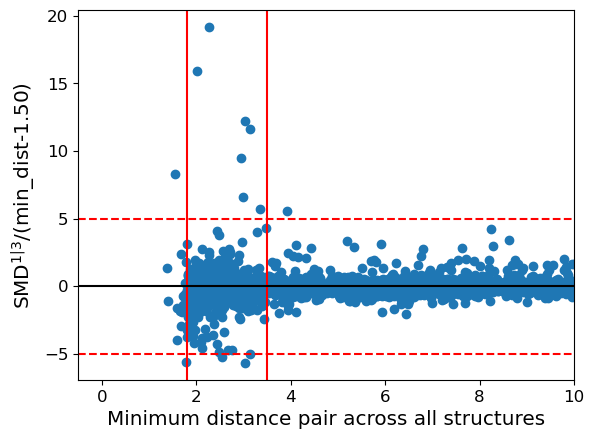

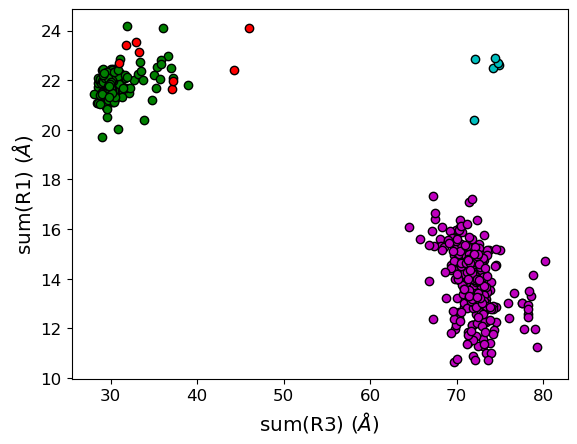

In [62]:
c1 = 1
c2 = 3

feats_0 = dist_analy.pca.triu_flatten(np.array(dist_mats_0), len(res_list_0))

inds_fc_0= [[j for j,l in enumerate(labels_0) if l==i ] for i in range(-1,max(labels_0)+1)]

smd_0, min_dist_0 = dist_analy.pca.calc_cluster_smd(inds_fc_0[c1], inds_fc_0[c2], feats_0, std = 'SMD')
r1r2_feat_0 = dist_analy.pca.plot_smd(c1, c2, feats_0, min_dist_0, smd_0, [res_list_0], [uniprot_seq_cdk2], [color_cdk2], xmax_cutoff=3.5, ycutoff=5, top=25)
dist_analy.pca.plot_r1r2(c1,c2,r1r2_feat_0, labels_0, dist_mats_0, color_list=['m', 'c', 'g', 'r'])

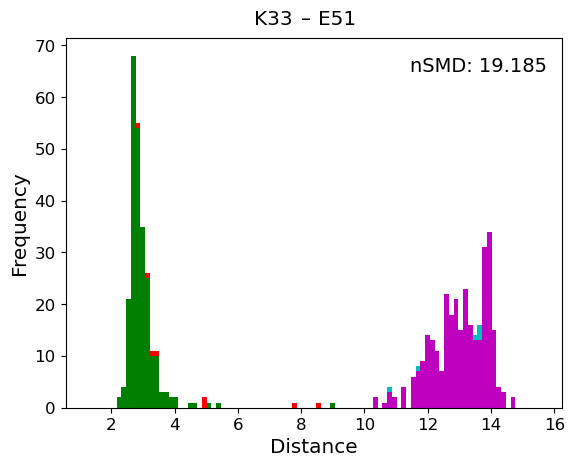

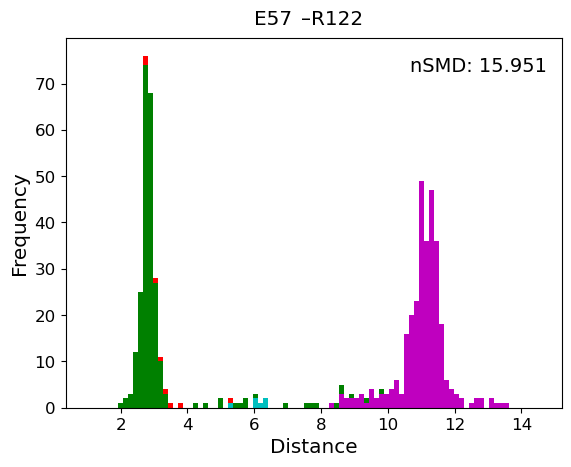

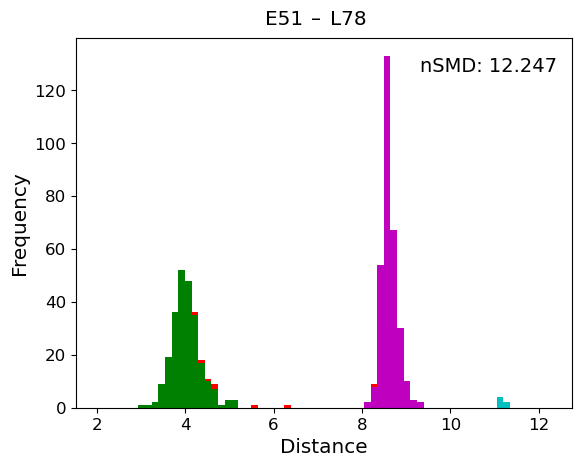

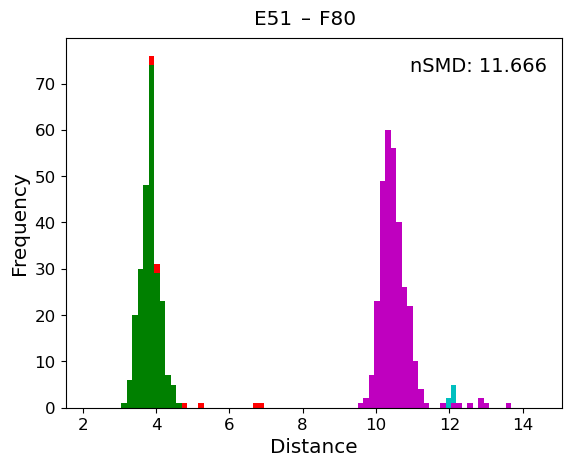

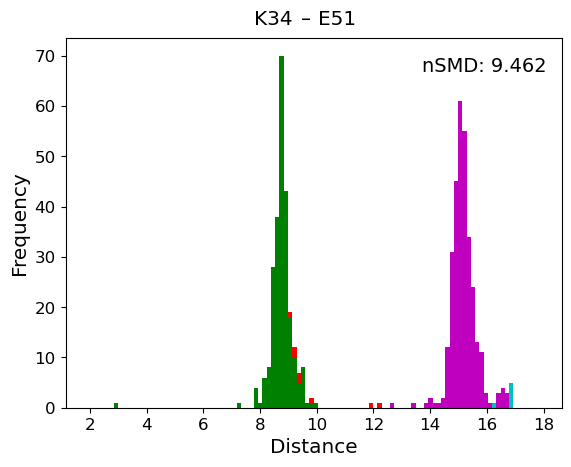

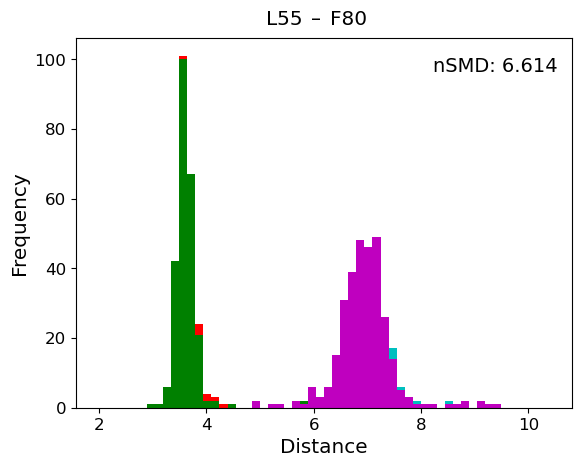

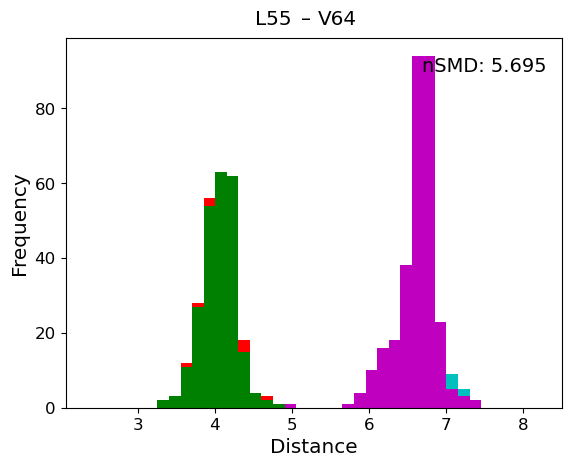

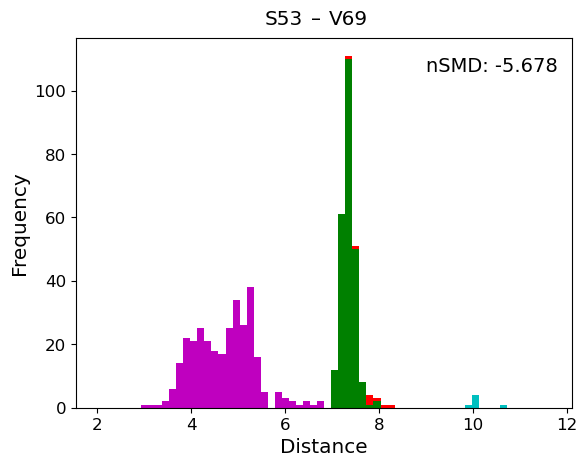

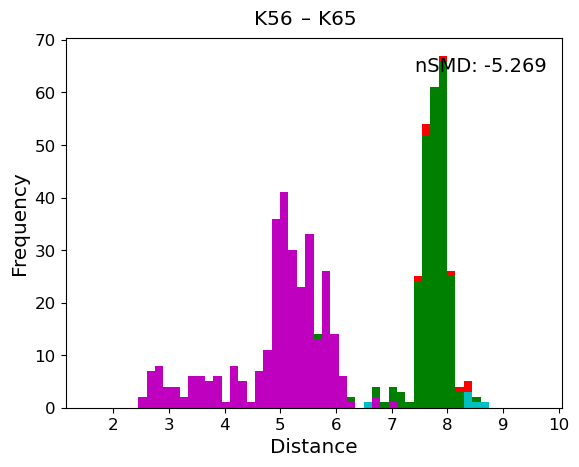

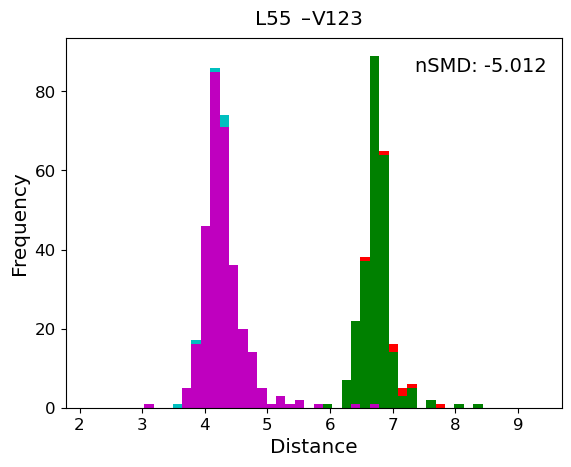

In [21]:
for r1,r2,index, shortest, smd in r1r2_feat_0:
    dist_analy.pca.plot_stacked_histogram(r1,r2,dist_mats_0,[res_list_0],labels_0,[uniprot_seq_cdk2],SMD=smd, color_list=['m', 'c', 'g', 'r'])

# ligand-only space

In [18]:
lig_dir = "./datafiles/lig_pdb_all/"
proc_dir = './datafiles/proc_pdb/CDK2/'
save_dir = "./datafiles/npy/lig/"

mat_list, pdb_list = [], []
for lig in glob(f"{lig_dir}/*.pdb"):
    pdb = lig.split('/')[-1].split('.')[0].split('_')[0]
    chain = lig.split('/')[-1].split('.')[0].split('_')[1]
    lig_fn = lig.split('/')[-1].split('.')[0]
    if (os.path.exists(f"{proc_dir}{pdb}_{chain}.pdb")) and (f"{pdb}_{chain}" in dist_mat_pdb_0):
        print(lig)
        pdb_list.append(lig)
        mat = get_shortest_dist_matrix(f"{proc_dir}{pdb}_{chain}.pdb", np.arange(1,300), chain, ligand_file=lig, ligand_chain=chain, save_fn=f"{save_dir}/{lig_fn}")
        mat_list.append(mat)
        # break

@> 2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2UZD_A_C85_1297.pdb
./datafiles/lig_pdb_all/3RPR_A_25Z_529.pdb
./datafiles/lig_pdb_all/3R9H_A_Z67_606.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2402 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2402 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 2176 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2176 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1JST_A_ATP_300.pdb
./datafiles/lig_pdb_all/5FP6_A_MFZ_1295.pdb


@> 2185 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2185 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/7S7A_A_8FI_302.pdb
./datafiles/lig_pdb_all/1OIY_C_N41_1298.pdb
./datafiles/lig_pdb_all/4RJ3_A_3QS_302.pdb


@> 2322 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2322 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2150 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2150 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2212 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2212 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s

./datafiles/lig_pdb_all/4BCP_C_T3C_1297.pdb
./datafiles/lig_pdb_all/4BGH_A_3I6_1001.pdb
./datafiles/lig_pdb_all/3RM7_A_19Z_654.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2273 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2273 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3RK9_A_09Z_483.pdb
./datafiles/lig_pdb_all/4FKG_A_4CK_300.pdb
./datafiles/lig_pdb_all/3R83_A_Z14_589.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2379 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2370 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/2C5O_C_CK2_1298.pdb
./datafiles/lig_pdb_all/1VYW_C_292_2300.pdb
./datafiles/lig_pdb_all/7ACK_C_R7B_301.pdb


@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2377 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2377 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2260 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2260 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/2C5O_A_CK2_1297.pdb
./datafiles/lig_pdb_all/3RJC_A_06Z_450.pdb
./datafiles/lig_pdb_all/1FVT_A_106_299.pdb


@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2398 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2396 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2335 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/1FIN_C_ATP_299.pdb
./datafiles/lig_pdb_all/3QHW_A_ADP_297.pdb
./datafiles/lig_pdb_all/1PXK_A_CK3_500.pdb


@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2336 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/lig_pdb_all/2R3R_A_6SC_501.pdb
./datafiles/lig_pdb_all/3R9N_A_Z68_529.pdb
./datafiles/lig_pdb_all/1QMZ_A_ATP_381.pdb


@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2204 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2406 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2406 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3R9D_A_X6B_590.pdb
./datafiles/lig_pdb_all/8CUR_A_OW6_301.pdb
./datafiles/lig_pdb_all/4BCP_A_T3C_1299.pdb


@> 2194 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2194 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2223 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2223 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/5AND_A_5JE_1295.pdb
./datafiles/lig_pdb_all/1GIH_A_1PU_501.pdb
./datafiles/lig_pdb_all/2BHE_A_BRY_1299.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3R8V_A_Z62_473.pdb
./datafiles/lig_pdb_all/2CJM_C_ATP_1298.pdb
./datafiles/lig_pdb_all/3RPO_A_24Z_778.pdb


@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 4462 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:4462 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:49 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3RAK_A_03Z_497.pdb
./datafiles/lig_pdb_all/4FKT_A_48K_301.pdb


@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2176 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2176 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3BHT_A_MFR_299.pdb
./datafiles/lig_pdb_all/5A14_A_LQ5_1297.pdb
./datafiles/lig_pdb_all/5FP6_A_MFZ_1296.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 15 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:15 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2220 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2220 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C6K_A_DT2_1299.pdb
./datafiles/lig_pdb_all/2EXM_A_ZIP_400.pdb
./datafiles/lig_pdb_all/2R3L_A_SCW_501.pdb


@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2313 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2313 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2517 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2517 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/lig_pdb_all/3RPY_A_27Z_470.pdb
./datafiles/lig_pdb_all/7B7S_C_T1T_301.pdb
./datafiles/lig_pdb_all/4FKI_A_09K_301.pdb


@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2347 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2347 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2311 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2311 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/7ZPC_A_JLC_301.pdb
./datafiles/lig_pdb_all/8ERD_A_WQ6_301.pdb
./datafiles/lig_pdb_all/4KD1_A_1QK_302.pdb


@> 2398 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2398 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2222 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2222 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2407 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2R3N_A_SCZ_501.pdb
./datafiles/lig_pdb_all/4BCO_A_T6Q_1299.pdb
./datafiles/lig_pdb_all/4EOJ_A_ATP_301.pdb


@> 2374 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2374 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2406 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2406 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/4CFU_A_2WC_1299.pdb
./datafiles/lig_pdb_all/2CCI_A_ATP_1297.pdb
./datafiles/lig_pdb_all/7MKX_A_ZGY_301.pdb


@> 47 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:47 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2317 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2317 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2284 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2284 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3EOC_A_T2A_501.pdb
./datafiles/lig_pdb_all/2VTO_A_LZ8_1299.pdb
./datafiles/lig_pdb_all/1H1S_C_4SP_1298.pdb


@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2354 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2354 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/2IW6_A_QQ2_1296.pdb
./datafiles/lig_pdb_all/3PXF_A_2AN_305.pdb
./datafiles/lig_pdb_all/3PXF_A_2AN_304.pdb


@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2330 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2330 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3DDP_A_RC8_299.pdb
./datafiles/lig_pdb_all/2C5Y_A_MTW_1298.pdb
./datafiles/lig_pdb_all/3R73_A_X87_920.pdb


@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2185 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2185 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2315 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2315 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1OIU_A_N76_1298.pdb
./datafiles/lig_pdb_all/4CFU_C_2WC_1297.pdb
./datafiles/lig_pdb_all/2CJM_A_ATP_1294.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2338 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2338 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3QZH_A_X69_839.pdb
./datafiles/lig_pdb_all/2R3O_A_2SC_501.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2199 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2199 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C5V_C_CK4_1297.pdb
./datafiles/lig_pdb_all/1PXN_A_CK6_500.pdb
./datafiles/lig_pdb_all/1GIJ_A_2PU_501.pdb


@> 2339 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2339 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2359 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2359 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2227 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2227 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/2VTR_A_LZB_1299.pdb
./datafiles/lig_pdb_all/4BCQ_C_TJF_1295.pdb
./datafiles/lig_pdb_all/4FKP_A_LS5_301.pdb


@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/lig_pdb_all/6GUF_C_23D_301.pdb
./datafiles/lig_pdb_all/5NEV_C_72L_301.pdb
./datafiles/lig_pdb_all/1PXP_A_CK8_500.pdb


@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2336 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2239 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2239 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/4EOS_C_1RO_301.pdb
./datafiles/lig_pdb_all/4FKL_A_CK2_300.pdb
./datafiles/lig_pdb_all/1H08_A_BWP_300.pdb


@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2189 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2189 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2204 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1P2A_A_5BN_301.pdb
./datafiles/lig_pdb_all/4BCM_C_T7Z_1295.pdb
./datafiles/lig_pdb_all/8FOW_A_7TW_304.pdb


@> 2270 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2270 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2307 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2307 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 8 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:8 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/1H0W_A_207_1299.pdb
./datafiles/lig_pdb_all/6Q49_A_HGQ_402.pdb
./datafiles/lig_pdb_all/1OI9_C_N20_1298.pdb


@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2336 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2362 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2362 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2R3F_A_SC8_501.pdb
./datafiles/lig_pdb_all/4EOK_A_4SP_301.pdb


@> 2228 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2228 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2396 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2396 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2VTJ_A_LZ4_1300.pdb
./datafiles/lig_pdb_all/7KJS_A_WG1_301.pdb
./datafiles/lig_pdb_all/3QHR_C_ADP_297.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C5X_C_MTW_1297.pdb
./datafiles/lig_pdb_all/2WXV_A_WXV_1299.pdb
./datafiles/lig_pdb_all/3RK5_A_07Z_436.pdb


@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2392 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2392 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3BHU_A_MHR_299.pdb
./datafiles/lig_pdb_all/3RAI_A_X85_923.pdb
./datafiles/lig_pdb_all/4CFW_C_SQ9_1297.pdb


@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2273 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2273 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2309 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2309 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:35 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2VTS_A_LZC_1299.pdb
./datafiles/lig_pdb_all/3WBL_A_PDY_302.pdb
./datafiles/lig_pdb_all/7NVQ_A_STU_301.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2239 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2239 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2358 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2358 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C5N_A_CK8_1297.pdb
./datafiles/lig_pdb_all/3RMF_A_20Z_496.pdb
./datafiles/lig_pdb_all/3TIY_A_TIY_311.pdb


@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 6 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:6 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2169 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2169 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2363 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2363 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6Q3B_A_PYZ_301.pdb
./datafiles/lig_pdb_all/1H00_A_FAP_1300.pdb
./datafiles/lig_pdb_all/6GUE_A_FB8_301.pdb


@> 2254 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2254 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2VTI_A_LZ3_1299.pdb
./datafiles/lig_pdb_all/3QQK_A_X02_497.pdb
./datafiles/lig_pdb_all/2BPM_C_529_1299.pdb


@> 2405 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2405 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2305 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2305 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2141 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2141 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:35 atoms and 1 coordinate set(s

./datafiles/lig_pdb_all/2VU3_A_LZE_1299.pdb
./datafiles/lig_pdb_all/4CFM_C_4QE_1297.pdb
./datafiles/lig_pdb_all/4EOM_A_ATP_301.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2383 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/4EOP_C_1RO_301.pdb
./datafiles/lig_pdb_all/4CFN_C_JYM_1295.pdb
./datafiles/lig_pdb_all/1E9H_A_INR_1298.pdb


@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2VTL_A_LZ5_1299.pdb
./datafiles/lig_pdb_all/3R6X_A_X84_778.pdb
./datafiles/lig_pdb_all/2C6T_A_DT5_1297.pdb


DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2411 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2411 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2121 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2121 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/4CFW_A_SQ9_1299.pdb
./datafiles/lig_pdb_all/1JVP_P_89E2_301.pdb
./datafiles/lig_pdb_all/2CCH_A_ATP_1297.pdb


@> 2379 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2379 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2205 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2205 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2392 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2392 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/2C5N_C_CK8_1298.pdb
./datafiles/lig_pdb_all/2W06_A_FRV_1300.pdb
./datafiles/lig_pdb_all/4EOO_C_ATP_301.pdb


@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3S2P_A_PMU_500.pdb
./datafiles/lig_pdb_all/2X1N_C_X1N_1298.pdb
./datafiles/lig_pdb_all/2B52_A_D42_299.pdb


@> 2152 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2152 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2386 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2386 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3DOG_C_NNN_299.pdb
./datafiles/lig_pdb_all/4CFN_A_JYM_1298.pdb
./datafiles/lig_pdb_all/3QTQ_A_X35_476.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2378 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 15 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:15 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2X1N_A_X1N_1297.pdb
./datafiles/lig_pdb_all/2VTH_A_LZ2_1300.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2076 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2076 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3PY0_A_SU9_301.pdb
./datafiles/lig_pdb_all/5FP5_A_1Y6_1297.pdb
./datafiles/lig_pdb_all/4CFX_C_G6T_1299.pdb


@> 2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2277 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 6 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:6 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2219 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2219 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2338 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2338 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6Q3B_A_PYZ_302.pdb
./datafiles/lig_pdb_all/2J9M_A_PY8_299.pdb
./datafiles/lig_pdb_all/2R3I_A_SCF_501.pdb


@> 2386 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2386 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2185 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2185 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1OGU_A_ST8_1298.pdb
./datafiles/lig_pdb_all/5CYI_A_55S_301.pdb
./datafiles/lig_pdb_all/1OGU_C_ST8_1297.pdb


@> 2338 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2338 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:13 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2R3P_A_3SC_501.pdb
./datafiles/lig_pdb_all/3QZI_A_X72_512.pdb
./datafiles/lig_pdb_all/1P5E_C_TBS_302.pdb


@> 2218 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2218 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2134 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2134 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2336 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:19 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2B55_A_D31_299.pdb
./datafiles/lig_pdb_all/5LMK_C_6ZK_301.pdb
./datafiles/lig_pdb_all/3EJ1_C_5BP_299.pdb


@> 2206 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2206 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2275 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2275 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2349 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2349 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1R78_A_FMD_299.pdb
./datafiles/lig_pdb_all/3ULI_A_1N3_299.pdb
./datafiles/lig_pdb_all/2I40_C_BLZ_401.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2345 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3TNW_C_F18_299.pdb
./datafiles/lig_pdb_all/3TI1_A_B49_299.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2151 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2151 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2443 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2443 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1B38_A_ATP_381.pdb
./datafiles/lig_pdb_all/1URW_A_I1P_1300.pdb
./datafiles/lig_pdb_all/4GCJ_A_X64_305.pdb


@> 2252 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2252 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2271 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2271 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2R3M_A_SCX_501.pdb
./datafiles/lig_pdb_all/6Q4G_A_HJK_301.pdb
./datafiles/lig_pdb_all/2BKZ_A_SBC_1299.pdb


@> 2286 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2286 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2364 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/5IEX_A_6AF_1001.pdb
./datafiles/lig_pdb_all/6GUB_A_F9Z_301.pdb
./datafiles/lig_pdb_all/3QZF_A_X66_299.pdb


@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2350 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2247 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2247 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2UZL_A_C94_1297.pdb
./datafiles/lig_pdb_all/6Q4K_A_HHW_301.pdb
./datafiles/lig_pdb_all/1CKP_A_PVB_299.pdb


@> 2137 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2137 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2427 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2427 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2215 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2215 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/7S9X_A_8KF_301.pdb
./datafiles/lig_pdb_all/2WIH_A_P48_1299.pdb
./datafiles/lig_pdb_all/2BTR_A_U73_300.pdb


@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4393 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:4393 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 43 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:43 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2280 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2280 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/7SA0_A_8KQ_306.pdb
./datafiles/lig_pdb_all/5IEV_A_R0N_1001.pdb
./datafiles/lig_pdb_all/4I3Z_A_ADP_301.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2419 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2419 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2161 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2161 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C4G_A_514_306.pdb
./datafiles/lig_pdb_all/4EOR_C_4SP_301.pdb


@> 2252 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2252 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2330 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2330 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/1W0X_C_OLO_1299.pdb
./datafiles/lig_pdb_all/3PXZ_A_2AN_299.pdb
./datafiles/lig_pdb_all/6Q4I_A_HGK_302.pdb


@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2348 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2348 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/4II5_A_ADP_301.pdb
./datafiles/lig_pdb_all/3R7U_A_X96_523.pdb
./datafiles/lig_pdb_all/8B54_C_P2V_302.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3QX2_A_X63_300.pdb
./datafiles/lig_pdb_all/3QXP_A_X64_300.pdb
./datafiles/lig_pdb_all/2VTT_A_LZD_1299.pdb


@> 2195 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2195 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2097 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2097 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2318 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2318 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2278 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2278 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s

./datafiles/lig_pdb_all/7RXO_A_80E_302.pdb
./datafiles/lig_pdb_all/2UZB_C_C75_1297.pdb
./datafiles/lig_pdb_all/2W1H_A_L0F_1299.pdb


@> 2311 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2311 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1H0V_A_UN4_1299.pdb
./datafiles/lig_pdb_all/3RZB_A_02Z_458.pdb
./datafiles/lig_pdb_all/3R7I_A_X9I_505.pdb


@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2242 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2242 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2350 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3MY5_A_RFZ_300.pdb
./datafiles/lig_pdb_all/6GUK_A_FC8_301.pdb
./datafiles/lig_pdb_all/6Q4K_A_HHW_302.pdb


DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2301 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2301 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6GUC_A_SU9_301.pdb
./datafiles/lig_pdb_all/6YLK_A_OY2_301.pdb


@> 2194 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2194 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 11 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:11 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6INL_A_AJR_900.pdb
./datafiles/lig_pdb_all/5ANE_A_SZL_1299.pdb
./datafiles/lig_pdb_all/1E1X_A_NW1_401.pdb


@> 2332 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2332 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2375 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2375 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3LFQ_A_A28_299.pdb
./datafiles/lig_pdb_all/4EOI_A_1RO_301.pdb
./datafiles/lig_pdb_all/7SA0_A_8KQ_305.pdb


@> 4393 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:4393 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 43 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:43 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2340 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2340 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2246 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2246 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/lig_pdb_all/3QWK_A_X62_493.pdb
./datafiles/lig_pdb_all/2C6L_A_DT4_1299.pdb
./datafiles/lig_pdb_all/1VYZ_A_N5B_300.pdb


@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2253 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2253 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2400 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2400 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2157 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2157 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1KE7_A_LS3_299.pdb
./datafiles/lig_pdb_all/8H6T_A_WZZ_301.pdb
./datafiles/lig_pdb_all/4BZD_A_D6I_1300.pdb


@> 2240 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2240 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2334 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2UZN_A_C96_1299.pdb
./datafiles/lig_pdb_all/3RPV_A_26Z_495.pdb
./datafiles/lig_pdb_all/6RIJ_C_K4W_301.pdb


@> 2260 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2260 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2406 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2406 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1KE8_A_LS4_299.pdb
./datafiles/lig_pdb_all/4EON_A_1RO_301.pdb
./datafiles/lig_pdb_all/3BHV_A_VAR_299.pdb


@> 2201 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2201 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2172 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2172 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3EZR_A_EZR_300.pdb
./datafiles/lig_pdb_all/5OO1_A_9Z2_301.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2217 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2217 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2313 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2313 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3R1Q_A_X75_616.pdb
./datafiles/lig_pdb_all/7S84_A_8IL_301.pdb
./datafiles/lig_pdb_all/7QHL_C_D5P_301.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2201 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2201 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2155 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2155 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:19 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3RKB_A_12Z_457.pdb
./datafiles/lig_pdb_all/3EZR_A_EZR_301.pdb
./datafiles/lig_pdb_all/5ANG_A_WY3_1299.pdb


@> 2302 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2302 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2407 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/lig_pdb_all/6GUH_A_FB8_301.pdb
./datafiles/lig_pdb_all/3PXZ_A_JWS_301.pdb
./datafiles/lig_pdb_all/2G9X_A_NU5_299.pdb


@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 11 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:11 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/lig_pdb_all/2VTM_A_LZM_1299.pdb
./datafiles/lig_pdb_all/1FVV_C_107_601.pdb
./datafiles/lig_pdb_all/1PKD_C_UCN_411.pdb


@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2371 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2371 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2234 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2234 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3UNK_A_0BY_299.pdb
./datafiles/lig_pdb_all/5JQ8_A_I73_301.pdb
./datafiles/lig_pdb_all/3R71_A_X86_800.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 2253 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2253 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1H1R_A_6CP_1298.pdb
./datafiles/lig_pdb_all/4EK8_A_16K_301.pdb


@> 2390 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2390 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 8 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:8 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2342 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3F5X_A_EZV_300.pdb
./datafiles/lig_pdb_all/6Q3F_A_HEW_301.pdb
./datafiles/lig_pdb_all/1W8C_A_N69_1301.pdb


@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2329 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2329 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3PXY_A_JWS_299.pdb
./datafiles/lig_pdb_all/3R8Z_A_Z63_440.pdb
./datafiles/lig_pdb_all/1H1P_C_CMG_1298.pdb


@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2288 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2288 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3DDQ_A_RRC_299.pdb
./datafiles/lig_pdb_all/1H01_A_FAL_301.pdb
./datafiles/lig_pdb_all/1HCK_A_ATP_400.pdb


@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2150 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2150 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1E1V_A_CMG_401.pdb
./datafiles/lig_pdb_all/1PYE_A_PM1_700.pdb
./datafiles/lig_pdb_all/3PXZ_A_2AN_300.pdb


@> 2121 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2121 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2379 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/1JVP_P_89E1_301.pdb
./datafiles/lig_pdb_all/3IGG_A_EFQ_999.pdb
./datafiles/lig_pdb_all/4EOQ_A_ATP_301.pdb


@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2252 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2252 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 8 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:8 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2359 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2359 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:37 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6Q48_A_HHQ_302.pdb
./datafiles/lig_pdb_all/4FX3_C_60K_301.pdb
./datafiles/lig_pdb_all/1H1Q_A_2A6_1298.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 15 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:15 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2405 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2234 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2234 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3QQJ_A_X11_300.pdb
./datafiles/lig_pdb_all/4EOL_C_1RO_301.pdb
./datafiles/lig_pdb_all/4EK6_A_10K_301.pdb


@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2370 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2UZE_A_C95_1297.pdb
./datafiles/lig_pdb_all/1PXM_A_CK5_500.pdb
./datafiles/lig_pdb_all/2WPA_C_889_1300.pdb


@> 2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2381 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2377 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2377 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/lig_pdb_all/1GY3_C_ATP_1298.pdb
./datafiles/lig_pdb_all/3QTR_A_X36_497.pdb
./datafiles/lig_pdb_all/2WEV_A_CK7_1297.pdb


@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2348 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2348 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:13 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/8B54_A_P2V_301.pdb
./datafiles/lig_pdb_all/6Q4D_A_HHT_301.pdb
./datafiles/lig_pdb_all/2R3H_A_SCE_501.pdb


@> 2384 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2384 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2293 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2293 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3TNW_A_F18_299.pdb
./datafiles/lig_pdb_all/3PY1_A_2AN_302.pdb
./datafiles/lig_pdb_all/3LFN_A_A27_299.pdb


@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2379 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2WEV_C_CK7_1298.pdb
./datafiles/lig_pdb_all/1GY3_A_ATP_1297.pdb
./datafiles/lig_pdb_all/2R3K_A_SCQ_501.pdb


@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2339 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2339 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2403 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2403 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 42 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:42 atoms and 1 coordinate set(s

./datafiles/lig_pdb_all/3LFS_A_A07_299.pdb
./datafiles/lig_pdb_all/4BCN_A_T9N_1299.pdb
./datafiles/lig_pdb_all/4BCK_A_T3E_1298.pdb


@> 2362 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2362 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2318 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2318 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3S0O_A_50Z_446.pdb
./datafiles/lig_pdb_all/6GVA_A_FCQ_301.pdb
./datafiles/lig_pdb_all/1H1R_C_6CP_1298.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2336 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2292 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2292 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s

./datafiles/lig_pdb_all/5ANJ_A_ZXC_1299.pdb
./datafiles/lig_pdb_all/3R7Y_A_Z04_484.pdb
./datafiles/lig_pdb_all/2FVD_A_LIA_299.pdb


@> 2211 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2211 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:19 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2339 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2339 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/2BTS_A_U32_1299.pdb
./datafiles/lig_pdb_all/6OQI_A_N14_301.pdb
./datafiles/lig_pdb_all/2B53_A_D23_299.pdb


@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2911 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2911 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2374 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2374 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2B54_A_D05_300.pdb
./datafiles/lig_pdb_all/4BCN_C_T9N_1296.pdb
./datafiles/lig_pdb_all/3QTU_A_X44_451.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2342 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2342 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2300 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2300 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2363 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2363 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/6GUB_C_F9Z_301.pdb
./datafiles/lig_pdb_all/4LYN_A_1YG_301.pdb
./datafiles/lig_pdb_all/4BCK_C_T3E_1295.pdb


@> 42 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:42 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:13 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2106 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2106 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6Q4D_A_HHT_302.pdb
./datafiles/lig_pdb_all/4NJ3_A_2KD_301.pdb
./datafiles/lig_pdb_all/1OIQ_A_HDU_1299.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2282 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2282 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3RK7_A_08Z_467.pdb
./datafiles/lig_pdb_all/1Y91_A_CT9_401.pdb
./datafiles/lig_pdb_all/1H1P_A_CMG_1298.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2141 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2141 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2V0D_A_C53_1299.pdb
./datafiles/lig_pdb_all/3MY5_C_RFZ_301.pdb
./datafiles/lig_pdb_all/4II5_C_ADP_301.pdb


@> 2368 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2368 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2412 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2412 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/4EOR_A_4SP_301.pdb
./datafiles/lig_pdb_all/2C4G_C_514_306.pdb
./datafiles/lig_pdb_all/4I3Z_C_ADP_301.pdb


@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2918 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2918 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2427 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/3PY1_A_2AN_301.pdb
./datafiles/lig_pdb_all/1PF8_A_SU9_500.pdb
./datafiles/lig_pdb_all/2WPA_A_889_1301.pdb


@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2UZE_C_C95_1297.pdb
./datafiles/lig_pdb_all/4EOI_C_1RO_301.pdb
./datafiles/lig_pdb_all/3SW4_A_18K_299.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2358 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2358 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 8 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:8 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1FQ1_B_ATP_381.pdb
./datafiles/lig_pdb_all/6Q4F_A_26D_301.pdb


@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3RAH_A_O1Z_516.pdb
./datafiles/lig_pdb_all/3RNI_A_21Z_424.pdb
./datafiles/lig_pdb_all/1H1Q_C_2A6_1298.pdb


@> 2116 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2116 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/5D1J_A_56H_4000.pdb
./datafiles/lig_pdb_all/3R8L_A_Z30_423.pdb
./datafiles/lig_pdb_all/6GUC_C_SU9_301.pdb


@> 2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:13 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2358 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2358 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6Q4D_A_HHT_303.pdb
./datafiles/lig_pdb_all/3BHV_C_VAR_299.pdb
./datafiles/lig_pdb_all/3TIZ_A_3TI_299.pdb


@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2398 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/4EON_C_1RO_301.pdb
./datafiles/lig_pdb_all/3QTZ_A_X42_453.pdb
./datafiles/lig_pdb_all/1YKR_A_628_299.pdb


@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2247 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3QZG_A_X67_471.pdb
./datafiles/lig_pdb_all/2R64_A_740_500.pdb
./datafiles/lig_pdb_all/3QQG_A_X06_300.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/1PKD_A_UCN_410.pdb
./datafiles/lig_pdb_all/3QRT_A_X14_535.pdb
./datafiles/lig_pdb_all/4EZ3_A_0S0_301.pdb


@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2334 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2215 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2215 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1PXL_A_CK4_500.pdb
./datafiles/lig_pdb_all/4FKW_A_62K_301.pdb


@> 2334 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2334 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 6 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:6 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2374 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2374 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/6Q3C_A_BYZ_301.pdb
./datafiles/lig_pdb_all/3R8U_A_Z31_465.pdb
./datafiles/lig_pdb_all/3QRU_A_X19_493.pdb


@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2334 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2309 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2309 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2269 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/6RIJ_A_K4W_301.pdb
./datafiles/lig_pdb_all/5JQ5_A_I74_302.pdb
./datafiles/lig_pdb_all/3R9O_A_Z71_401.pdb


@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2285 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2285 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2367 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2367 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 11 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:11 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1OIR_A_HDY_1298.pdb
./datafiles/lig_pdb_all/6Q4C_A_HH8_301.pdb
./datafiles/lig_pdb_all/2C6O_A_4SP_1297.pdb


@> 2227 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2227 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2263 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2263 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2298 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2298 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:13 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3EZV_A_EZV_300.pdb
./datafiles/lig_pdb_all/2VTP_A_LZ9_1299.pdb
./datafiles/lig_pdb_all/3R8M_A_Z19_486.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2303 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2303 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C69_A_CT8_1299.pdb
./datafiles/lig_pdb_all/3PJ8_A_404_299.pdb
./datafiles/lig_pdb_all/3QTX_A_X43_299.pdb


@> 2206 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2206 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2405 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2398 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/2W17_A_I19_1300.pdb
./datafiles/lig_pdb_all/2WIH_C_P48_1299.pdb
./datafiles/lig_pdb_all/3F5X_C_EZV_300.pdb


@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2217 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2217 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2383 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2383 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:34 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3SW7_A_19K_299.pdb
./datafiles/lig_pdb_all/2UZL_C_C94_1297.pdb
./datafiles/lig_pdb_all/2G9X_C_NU5_299.pdb


@> 2324 atoms and 1 coordinate set(s) were parsed in 0.09s.
DEBUG:.prody:2324 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:13 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6Q4D_A_HHT_306.pdb
./datafiles/lig_pdb_all/1B39_A_ATP_381.pdb


@> 2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2335 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2238 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2238 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2322 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2322 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2397 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2397 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s

./datafiles/lig_pdb_all/4FKR_A_45K_301.pdb
./datafiles/lig_pdb_all/3NS9_A_NS9_0.pdb
./datafiles/lig_pdb_all/2BKZ_C_SBC_1298.pdb


@> 2297 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2297 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2273 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2273 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/7QHL_A_D5P_301.pdb
./datafiles/lig_pdb_all/3LE6_A_2BZ_299.pdb
./datafiles/lig_pdb_all/2UZB_A_C75_1297.pdb


@> 2145 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2145 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:13 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2290 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2290 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 11 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:11 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3DDQ_C_RRC_299.pdb
./datafiles/lig_pdb_all/6Q4D_A_HHT_304.pdb
./datafiles/lig_pdb_all/6Q4E_A_HH5_303.pdb


@> 2334 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2334 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 6 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:6 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6Q3C_A_BYZ_302.pdb
./datafiles/lig_pdb_all/3R1S_A_X73_647.pdb
./datafiles/lig_pdb_all/5OO3_A_9ZB_301.pdb


@> 2284 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2284 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C6M_A_DT5_1297.pdb
./datafiles/lig_pdb_all/3R28_A_XA0_782.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2130 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2130 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2262 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2262 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3S00_A_Z60_461.pdb
./datafiles/lig_pdb_all/4CFV_C_75X_1297.pdb
./datafiles/lig_pdb_all/1DI8_A_DTQ_500.pdb


@> 2328 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2328 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2339 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2339 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/4EK5_A_03K_300.pdb
./datafiles/lig_pdb_all/3UNJ_A_0BX_299.pdb
./datafiles/lig_pdb_all/7VDU_A_65L_301.pdb


@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C68_A_CT6_1297.pdb
./datafiles/lig_pdb_all/3RAL_A_04Z_499.pdb
./datafiles/lig_pdb_all/3R8P_A_Z46_511.pdb


@> 2303 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2303 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2227 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2227 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:35 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/5OSM_A_AEQ_301.pdb
./datafiles/lig_pdb_all/7S85_A_8IQ_303.pdb
./datafiles/lig_pdb_all/4EZ7_A_STU_301.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:37 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2268 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2268 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2367 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2367 atoms and 1 coordinate set(s) were parsed in 0.03s.


./datafiles/lig_pdb_all/4FX3_A_60K_301.pdb
./datafiles/lig_pdb_all/5K4J_A_6QB_301.pdb
./datafiles/lig_pdb_all/4EOL_A_1RO_301.pdb


@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3R7V_A_Z02_490.pdb
./datafiles/lig_pdb_all/5L2W_A_1QK_900.pdb


@> 2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2244 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 9 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:9 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2210 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2210 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2324 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:13 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2VTA_A_LZ1_1301.pdb
./datafiles/lig_pdb_all/4EOQ_C_ATP_301.pdb
./datafiles/lig_pdb_all/6Q4D_A_HHT_305.pdb


@> 2246 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2246 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2237 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2237 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2418 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2418 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1KE6_A_LS2_299.pdb
./datafiles/lig_pdb_all/6YL1_A_OWN_301.pdb
./datafiles/lig_pdb_all/4CFV_A_75X_1299.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2337 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2337 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2365 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2365 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3QQH_A_X0A_303.pdb
./datafiles/lig_pdb_all/6Q4J_A_HHB_303.pdb
./datafiles/lig_pdb_all/1PXI_A_CK1_500.pdb


@> 2250 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2250 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2197 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2197 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2398 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1KE9_A_LS5_299.pdb
./datafiles/lig_pdb_all/8FP0_A_RRC_303.pdb
./datafiles/lig_pdb_all/1FIN_A_ATP_299.pdb


@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2396 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2179 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2179 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3QHW_C_ADP_297.pdb
./datafiles/lig_pdb_all/2VV9_A_IM9_1300.pdb
./datafiles/lig_pdb_all/2WXV_C_WXV_1299.pdb


@> 2370 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2370 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2153 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2153 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2305 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2305 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:36 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/7ACK_A_R7B_301.pdb
./datafiles/lig_pdb_all/2IW9_C_4SP_1297.pdb
./datafiles/lig_pdb_all/3EID_A_PO5_299.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C5X_A_MTW_1297.pdb
./datafiles/lig_pdb_all/4FKJ_A_11K_301.pdb


@> 2314 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2314 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2296 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2296 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:61 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/8FP5_A_ATP_302.pdb
./datafiles/lig_pdb_all/5IEY_A_6AE_1001.pdb
./datafiles/lig_pdb_all/6JGM_A_AQG_900.pdb


@> 2314 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2314 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2380 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2380 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2269 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/7UG1_A_N5R_301.pdb
./datafiles/lig_pdb_all/1OI9_A_N20_1298.pdb
./datafiles/lig_pdb_all/3QTS_A_X46_299.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2402 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2402 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2IW9_A_4SP_1298.pdb
./datafiles/lig_pdb_all/3QTW_A_X3A_451.pdb
./datafiles/lig_pdb_all/1JST_C_ATP_300.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1Y8Y_A_CT7_401.pdb
./datafiles/lig_pdb_all/1PXO_A_CK7_500.pdb
./datafiles/lig_pdb_all/2CCH_C_ATP_1297.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2174 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2174 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2300 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2300 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C6T_C_DT5_1297.pdb
./datafiles/lig_pdb_all/3BHT_C_MFR_299.pdb
./datafiles/lig_pdb_all/4EK4_A_1CK_301.pdb


@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2389 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2389 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1H07_A_MFQ_302.pdb
./datafiles/lig_pdb_all/1E9H_C_INR_1298.pdb
./datafiles/lig_pdb_all/4CFM_A_4QE_1297.pdb


@> 2278 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2278 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 8 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:8 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1WCC_A_CIG_1299.pdb
./datafiles/lig_pdb_all/2BPM_A_529_1299.pdb


@> 2354 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2354 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2316 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2316 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3RM6_A_18Z_478.pdb
./datafiles/lig_pdb_all/1JSV_A_U55_400.pdb
./datafiles/lig_pdb_all/1QMZ_C_ATP_381.pdb


@> 2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2208 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:19 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4741 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:4741 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:37 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1DM2_A_HMD_400.pdb
./datafiles/lig_pdb_all/4FKU_A_60K_301.pdb
./datafiles/lig_pdb_all/4FKU_A_60K_303.pdb


@> 4741 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:4741 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:37 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2400 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2400 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 47 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:47 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2297 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2297 atoms and 1 coordinate set(s) were parsed in 0.02s.


./datafiles/lig_pdb_all/8H6P_A_WZU_301.pdb
./datafiles/lig_pdb_all/7MKX_C_ZGY_301.pdb
./datafiles/lig_pdb_all/3EOC_C_T2A_501.pdb


@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2169 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2169 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2288 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2288 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2DS1_A_1CD_501.pdb
./datafiles/lig_pdb_all/1H00_A_FCP_1400.pdb
./datafiles/lig_pdb_all/1H01_A_FBL_302.pdb


@> 2309 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2309 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2342 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2314 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2314 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/7B7S_A_T1T_301.pdb
./datafiles/lig_pdb_all/1GZ8_A_MBP_1300.pdb
./datafiles/lig_pdb_all/7UG1_A_N5R_302.pdb


@> 2212 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2212 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2263 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2263 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1G5S_A_I17_400.pdb
./datafiles/lig_pdb_all/4EOJ_C_ATP_301.pdb
./datafiles/lig_pdb_all/3ROY_A_22Z_781.pdb


@> 2282 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2282 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:19 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3FZ1_A_B98_299.pdb
./datafiles/lig_pdb_all/3PY1_A_SU9_300.pdb


@> 2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2345 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2C6I_A_DT1_1299.pdb
./datafiles/lig_pdb_all/3QQF_A_X07_543.pdb
./datafiles/lig_pdb_all/3QWJ_A_X6A_483.pdb


@> 2375 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2375 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2076 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2076 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/4BCM_A_T7Z_1297.pdb
./datafiles/lig_pdb_all/3QL8_A_X01_300.pdb
./datafiles/lig_pdb_all/5FP5_A_1Y6_1298.pdb


@> 2380 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2380 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2357 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2357 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2319 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2319 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/5NEV_A_72L_301.pdb
./datafiles/lig_pdb_all/2CLX_A_F18_1299.pdb
./datafiles/lig_pdb_all/8ERN_A_WQK_402.pdb


@> 2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2383 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2246 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2246 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2387 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6GUF_A_23D_301.pdb
./datafiles/lig_pdb_all/1KE5_A_LS1_299.pdb
./datafiles/lig_pdb_all/4EOS_A_1RO_301.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2158 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2158 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:54 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3R1Y_A_X76_488.pdb
./datafiles/lig_pdb_all/2UUE_A_MTZ_1297.pdb
./datafiles/lig_pdb_all/4ACM_A_7YG_1302.pdb


@> 2365 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2365 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1PXJ_A_CK2_500.pdb
./datafiles/lig_pdb_all/2UUE_C_MTZ_1298.pdb


@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2407 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2210 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2210 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3DDP_C_RC8_299.pdb
./datafiles/lig_pdb_all/4CFX_A_G6T_1299.pdb
./datafiles/lig_pdb_all/2BHH_A_RYU_1299.pdb


@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2204 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2230 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2230 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:35 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2162 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2162 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/5ANK_A_RJI_1299.pdb
./datafiles/lig_pdb_all/1AQ1_A_STU_299.pdb
./datafiles/lig_pdb_all/4D1X_A_ESJ_1299.pdb


@> 2211 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2211 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2396 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2396 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2VTQ_A_LZA_1299.pdb
./datafiles/lig_pdb_all/3QX4_A_X4B_454.pdb
./datafiles/lig_pdb_all/3QHR_A_ADP_297.pdb


@> 2242 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2242 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1GII_A_1PU_501.pdb
./datafiles/lig_pdb_all/3BHU_C_MHR_299.pdb
./datafiles/lig_pdb_all/3PXQ_A_2AN_300.pdb


@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2350 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2253 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2253 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2405 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2WIP_C_P49_1297.pdb
./datafiles/lig_pdb_all/2R3J_A_SCJ_501.pdb
./datafiles/lig_pdb_all/4EOK_C_4SP_301.pdb


@> 2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2304 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2304 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1VYW_A_292_2300.pdb
./datafiles/lig_pdb_all/1OIY_A_N41_1298.pdb
./datafiles/lig_pdb_all/7S4T_A_88O_302.pdb


@> 2204 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2204 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2372 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2372 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/8FOW_A_1QK_303.pdb
./datafiles/lig_pdb_all/4EOO_A_ATP_302.pdb
./datafiles/lig_pdb_all/2UZD_C_C85_1297.pdb


@> 2382 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:2382 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2377 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:13 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s

./datafiles/lig_pdb_all/1FVV_A_107_501.pdb
./datafiles/lig_pdb_all/1P5E_A_TBS_301.pdb
./datafiles/lig_pdb_all/3QQL_A_X03_299.pdb


@> 2167 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2167 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2197 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2197 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2394 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2394 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1V1K_A_3FP_299.pdb
./datafiles/lig_pdb_all/8FP0_A_7TW_304.pdb
./datafiles/lig_pdb_all/4EOP_A_1RO_301.pdb


@> 2211 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2211 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:19 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2355 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2355 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2VTN_A_LZ7_1299.pdb
./datafiles/lig_pdb_all/4BCQ_A_TJF_1296.pdb
./datafiles/lig_pdb_all/3QU0_A_X40_454.pdb


@> 2182 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2182 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2347 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2347 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 7 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:7 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2245 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2W05_A_FRT_1299.pdb
./datafiles/lig_pdb_all/6Q4B_A_HHN_301.pdb
./datafiles/lig_pdb_all/1H07_A_MFP_301.pdb


@> 2299 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2299 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/4FKO_A_20K_301.pdb
./datafiles/lig_pdb_all/2A0C_X_CK9_500.pdb
./datafiles/lig_pdb_all/6GUE_C_FB8_301.pdb


@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2283 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2283 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:18 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3PXQ_A_2AN_301.pdb
./datafiles/lig_pdb_all/5OO0_A_9YZ_301.pdb


@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2291 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2291 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2205 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2205 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:35 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2WIP_A_P49_1299.pdb
./datafiles/lig_pdb_all/5OSJ_A_AAK_301.pdb
./datafiles/lig_pdb_all/4EOM_C_ATP_301.pdb


@> 2254 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2254 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 10 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:10 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2308 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2308 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:36 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/5ANI_A_ES4_1299.pdb
./datafiles/lig_pdb_all/2A4L_A_RRC_300.pdb
./datafiles/lig_pdb_all/5A14_A_LQ5_1298.pdb


@> 4339 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:4339 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 42 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:42 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/4FKS_A_46K_301.pdb
./datafiles/lig_pdb_all/3DOG_A_NNN_299.pdb
./datafiles/lig_pdb_all/2IW6_C_QQ2_1296.pdb


@> 2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2378 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2364 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s

./datafiles/lig_pdb_all/1H1S_A_4SP_1298.pdb
./datafiles/lig_pdb_all/5MHQ_A_8QT_301.pdb
./datafiles/lig_pdb_all/2CCI_C_ATP_1297.pdb


@> 2344 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2344 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 7 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:7 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2361 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2361 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:35 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2199 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2199 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/6Q4A_A_HGW_301.pdb
./datafiles/lig_pdb_all/4ERW_A_STU_301.pdb
./datafiles/lig_pdb_all/2DUV_A_371_501.pdb


@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2307 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2307 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:31 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/4EZ7_A_2AN_303.pdb
./datafiles/lig_pdb_all/2I40_A_BLZ_301.pdb


@> 2372 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2372 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2409 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2409 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.01s.


./datafiles/lig_pdb_all/2XMY_A_CDK_500.pdb
./datafiles/lig_pdb_all/7RWF_A_7TW_302.pdb
./datafiles/lig_pdb_all/3QXO_A_X65_668.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2196 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2196 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2240 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2240 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2331 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:19 atoms and 1 coordinate set(s

./datafiles/lig_pdb_all/1OIT_A_HDT_1299.pdb
./datafiles/lig_pdb_all/3IG7_A_EFP_999.pdb
./datafiles/lig_pdb_all/3EJ1_A_5BP_299.pdb


@> 2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2391 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2320 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2320 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2130 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2130 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/5LMK_A_6ZK_301.pdb
./datafiles/lig_pdb_all/2R3Q_A_5SC_501.pdb
./datafiles/lig_pdb_all/2IW8_C_4SP_1297.pdb


@> 2270 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2270 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2350 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2350 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/7M2F_A_YOS_901.pdb
./datafiles/lig_pdb_all/4EZ7_A_2AN_302.pdb
./datafiles/lig_pdb_all/6Q4H_A_HGH_301.pdb


@> 2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2366 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2163 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2163 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2325 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2325 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:26 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3R7E_A_X88_919.pdb
./datafiles/lig_pdb_all/4BCO_C_T6Q_1298.pdb
./datafiles/lig_pdb_all/3SQQ_A_99Z_456.pdb


@> 2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2231 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2250 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2250 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2217 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2217 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:32 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3S1H_A_56Z_479.pdb
./datafiles/lig_pdb_all/4FKQ_A_42K_301.pdb
./datafiles/lig_pdb_all/4FKV_A_61K_301.pdb


@> 2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2399 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2378 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:2378 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/3PXQ_A_2AN_302.pdb
./datafiles/lig_pdb_all/2C5V_A_CK4_1297.pdb


@> 2239 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2239 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2134 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2134 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2321 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:23 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/1H08_A_BYP_299.pdb
./datafiles/lig_pdb_all/1OIU_C_N76_1298.pdb
./datafiles/lig_pdb_all/2UZO_A_C62_1297.pdb


@> 2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2388 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2228 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2228 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2318 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2318 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:24 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/5CYI_C_55S_301.pdb
./datafiles/lig_pdb_all/7RA5_A_3I3_301.pdb
./datafiles/lig_pdb_all/2R3G_A_SC9_501.pdb


@> 2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2395 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
DEBUG:.prody:2379 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
DEBUG:.prody:27 atoms and 1 coordinate set(s) were parsed in 0.00s.


./datafiles/lig_pdb_all/2IW8_A_4SP_1298.pdb
./datafiles/lig_pdb_all/2XNB_A_Y8L_1299.pdb


In [26]:
lig_dir = "./datafiles/lig_pdb_all/"
proc_dir = './datafiles/proc_pdb/CDK2/'
save_dir = "./datafiles/npy/lig/"

mat_list, lig_pdb_list, pdb_list, chain_list, lig_list, res_num_list = [], [], [] ,[], [], []
for lig_npy in glob(save_dir+"*.npy"):
    lig_fn = lig_npy.split('/')[-1].split('.')[0]
    pdb, chain, lig_id, res_num = lig_fn.split('_')

    mat = np.load(lig_npy, allow_pickle=True)
    mat_list.append(mat[0])
    lig_pdb_list.append(lig_fn)
    pdb_list.append(pdb)
    chain_list.append(chain)
    lig_list.append(lig_id)
    res_num_list.append(res_num)



In [27]:
lig_pca = pd.DataFrame({"lig_pdb": lig_pdb_list, "PDB": pdb_list, "chain": chain_list, "LIG": lig_list, "res_num": res_num_list})

lig_pca_nodup = lig_pca.drop_duplicates(["PDB", "chain", "LIG"], keep=False)

Cumulative explained variance > 0.8: 0.29, 0.18, 0.12, 0.09, 0.08, 0.06
4 ['6Q49_A_HGQ_402' '6Q3F_A_HEW_301' '5OO0_A_9YZ_301' '5OSJ_A_AAK_301']
488 ['3DDP_A_RC8_299' '2C5Y_A_MTW_1298' '3R73_A_X87_920' '1OIU_A_N76_1298'
 '3QZH_A_X69_839' '2CJM_A_ATP_1294' '2R3O_A_2SC_501' '1PXN_A_CK6_500'
 '2C5V_C_CK4_1297' '4CFU_C_2WC_1297' '2VTR_A_LZB_1299' '1GIJ_A_2PU_501'
 '4BCQ_C_TJF_1295' '6GUF_C_23D_301' '5NEV_C_72L_301' '4FKP_A_LS5_301'
 '4EOS_C_1RO_301' '4FKL_A_CK2_300' '1H08_A_BWP_300' '1PXP_A_CK8_500'
 '2EXM_A_ZIP_400' '2R3L_A_SCW_501' '2C6K_A_DT2_1299' '8ERD_A_WQ6_301'
 '3RPY_A_27Z_470' '4FKI_A_09K_301' '7B7S_C_T1T_301' '7ZPC_A_JLC_301'
 '4CFU_A_2WC_1299' '4EOJ_A_ATP_301' '4KD1_A_1QK_302' '4BCO_A_T6Q_1299'
 '2R3N_A_SCZ_501' '2CCI_A_ATP_1297' '7MKX_A_ZGY_301' '2VTO_A_LZ8_1299'
 '2IW6_A_QQ2_1296' '1H1S_C_4SP_1298' '3EOC_A_T2A_501' '3R9N_A_Z68_529'
 '8CUR_A_OW6_301' '1QMZ_A_ATP_381' '3R9D_A_X6B_590' '4BCP_A_T3C_1299'
 '3R8V_A_Z62_473' '2CJM_C_ATP_1298' '5AND_A_5JE_1295' '1GIH_A_1PU_501'
 '2BHE_

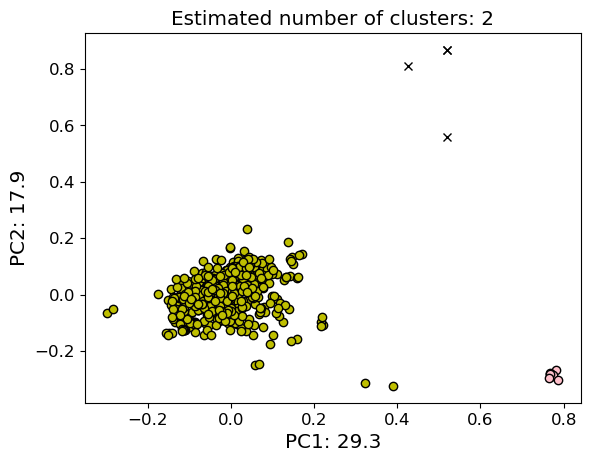

In [102]:
dist_mat_lig_1 = np.array(mat_list)[lig_pca_nodup.index,][:,ind_list_0]

proj_coords, var_ratio, npy_pca = dist_analy.pca.get_pca(np.reciprocal(dist_mat_lig_1), cumsum=0.8)
labels, hdb = dist_analy.pca.pca_hdbscan(proj_coords, var_ratio, color_list = ["y", "pink"])
inds_fc = [[j for j,l in enumerate(labels) if l==i ] for i in range(-1,max(labels)+1)]

for ind_fc in inds_fc:
    print(len(ind_fc), lig_pca_nodup.iloc[ind_fc].lig_pdb.values)


In [106]:
df_pca_lo = pd.DataFrame({"PDB_chain_lig_resnum": lig_pca_nodup.lig_pdb.values, \
                    "pca1": proj_coords[:,0],"pca2": proj_coords[:,1], \
                    "label":labels, "PDB": lig_pca_nodup.PDB.values, \
                    "LIG": lig_pca_nodup.LIG.values, "PDB_chain":lig_pca_nodup.lig_pdb.str[:6]})
txt_dir =  {"PDB_chain_lig_resnum:N":"PDB", "label:N":"label", "LIG:N":"LIG"}

jchart = alt_pca_hdbscan_figure(df_pca_lo[["PDB_chain_lig_resnum", "pca1", "pca2", "label", "LIG"]], txt_dir)
jchart

JupyterChart(spec={'config': {'view': {'continuousWidth': 300, 'continuousHeight': 300, 'strokeWidth': 0}}, 'h…

In [134]:
df_q = jchart_query(df_pca_lo[["PDB_chain_lig_resnum", "pca1", "pca2", "label",]], jchart, return_col = ["PDB_chain_lig_resnum", "label"])

rec_list = [f"{proc_dir}/{pdb[:6]}.pdb" for pdb in df_q.PDB_chain_lig_resnum]
chain_list = [pdb_chain[5] for pdb_chain in df_q.PDB_chain_lig_resnum]
lig_list = [f"{lig_dir}/{pdb}.pdb" for pdb in df_q.PDB_chain_lig_resnum]

lig_color_list = ['yellow', 'pink', 'black']

py3Dmol_lig_pose(rec_list, chain_list, lig_list, chain_list,\
                 rec_style={"cartoon": {"style": "edged", 'color': "grey"}},
                 lig_style={"stick": {'color': lig_color_list[df_q.label.values[0]]}})


ValueError: expr cannot be an empty string

In [133]:
df_pca_lr = df_pca_lo.rename(columns={"label": "lo_label"})\
                     .merge(df_pca_ro.rename(columns={"label": "ro_label"})[["PDB_chain", "ro_label"]], on="PDB_chain", how="left")
df_pca_lr["LR_label"] = list(zip(df_pca_lr.ro_label, df_pca_lr.lo_label))
df_pca_lr.LR_label.value_counts()


LR_label
(0, 0)     286
(2, 0)     195
(0, 1)       9
(3, 0)       4
(0, -1)      4
(1, 0)       3
Name: count, dtype: int64

In [136]:
df_tmp = df_pca_lr[df_pca_lr.LR_label == (0,1)].sample(5)

rec_list = [f"{proc_dir}/{pdb[:6]}.pdb" for pdb in df_tmp.PDB_chain_lig_resnum]
chain_list = [pdb_chain[5] for pdb_chain in df_tmp.PDB_chain_lig_resnum]
lig_list = [f"{lig_dir}/{pdb}.pdb" for pdb in df_tmp.PDB_chain_lig_resnum]

rec_color_list = ['purple', 'cyan', 'green', 'red']
lig_color_list = ['yellow', 'pink',]

py3Dmol_lig_pose(rec_list, chain_list, lig_list, chain_list,\
                 rec_style={"cartoon": {"style": "edged", 'color': rec_color_list[df_tmp.ro_label.values[0]]}},
                 lig_style={"stick": {'color': lig_color_list[df_tmp.lo_label.values[0]]}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

interactive(children=(IntSlider(value=0, description='index', max=4), Output()), _dom_classes=('widget-interac…